# Calibration 

In [1]:
# ensure relative imports are correctly imported
import sys
sys.path.insert(0, '../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.QuantumMachine import QuantumMachine
from qm.qua import *

from instruments import LabBrick, MetaInstrument, Sa124
from instruments.quantum_machines.configuration import *

from measurements.routines import resonator_spectroscopy
from measurements.routines import resonator_power_level
from measurements.routines import qubit_spectroscopy
from measurements.routines import power_rabi
from measurements.routines import qubit_T1

In [3]:
# define a qubit
class Qubit(MetaInstrument):
    """
    Encapsulates a qubit.
    """
    def __init__(self, name: str, lo_freq: float):
        self.name = name
        self.lo_freq = lo_freq
    
    def _create_parameters(self):
        print("created dummy parameters for " + self.name)
    
    def _create_yaml_map(self):
        return {
            'lo_freq': self.lo_freq
        }

# instantiate the qubit
qubit = Qubit(name='qubit', lo_freq=4.165e9)

In [4]:
# define a resonator
class Resonator(MetaInstrument):
    """
    Encapsulates a resonator.
    """
    def __init__(self, name: str, lo_freq: float):
        self.name = name
        self.lo_freq = lo_freq
    
    def _create_parameters(self):
        print("created dummy parameters for " + self.name)
    
    def _create_yaml_map(self):
        return {
            'lo_freq': self.lo_freq
        }

# instantiate the resonator
rr = Resonator(name='rr', lo_freq=8.7571e9)

In [5]:
sa = Sa124(name='sa', serial_number=19184645, center=8.7e9, span=200e6)

Trying to initialize sa
Error -8: {'error_string': b'Device not found'} in sa_open_device_by_serial()
Closing and reinitializing it. Use configure_sweep() to change sweep parameters instead of __init__()
Error -3: {'error_string': b'Device specified is not open'} in sa_close_device()


NameError: name 'exit' is not defined

In [6]:
qmm = QuantumMachinesManager()
qm = qmm.open_qm(config)

2021-04-20 14:38:39,484 - qm - INFO - Performing health check
2021-04-20 14:38:39,489 - qm - INFO - Health check passed


In [7]:
# start the labbricks
lb_q = LabBrick(name='lb_q', serial_number=25331, element=qubit, power=15)
lb_rr = LabBrick(name='lb_rr', serial_number=25335, element=rr, power=13)

Trying to initialize lb_q
Connnected to LabBrick 25331
creating parameters...
Initializing device...
Successfully set frequency to 4.16E+09
Successfully set power to +15
Trying to initialize lb_rr
Connnected to LabBrick 25335
creating parameters...
Initializing device...
Successfully set frequency to 8.76E+09
Successfully set power to +13


## IQ offset

In [8]:
rr_dcOffsetI = 0.011558358245951837
rr_dcOffsetQ = -0.00947436793762317
rr_mixerGainCorrection = -0.15430981633780644
rr_mixerPhaseCorrection = 0.0212698142172309

q_dcOffsetI = -0.00647755186574999 
q_dcOffsetQ = -0.011624171790995147
q_mixerGainCorrection = -0.19547425898369505
q_mixerPhaseCorrection = 0.05154287262922243

# after this step we have tuned the IQ mixer.
qm.set_output_dc_offset_by_element("rr", "I", float(rr_dcOffsetI)) 
qm.set_output_dc_offset_by_element("rr", "Q", float(rr_dcOffsetQ))
qm.set_mixer_correction("mixer_rr", rr_IF, rr_LO, IQ_imbalance(rr_mixerGainCorrection, rr_mixerPhaseCorrection))
qm.set_output_dc_offset_by_element("qubit", "I", float(q_dcOffsetI)) 
qm.set_output_dc_offset_by_element("qubit", "Q", float(q_dcOffsetQ))
qm.set_mixer_correction("mixer_qubit", qubit_IF, qubit_LO, IQ_imbalance(rr_mixerGainCorrection, q_mixerPhaseCorrection))

In [9]:
q_lo_freq=4.165e9
rr_lo_freq=8.7571e9

## Spectrum 

In [11]:
with program() as cw:
    with infinite_loop_():
        play("CW", "rr")
        play("CW", "qubit")

# Execute the script
job = qm.execute(cw)

2021-04-20 10:27:40,100 - qm - INFO - Flags: 
2021-04-20 10:27:40,101 - qm - INFO - Executing high level program


In [ ]:
job.halt()

Configured sweep! Sweep info: 
{'center': 8757100000.0Hz, 'span': 200000000.0Hz, 'rbw': 250000.0Hz, 'ref_power': -20dBm, 'status': 0, 'sweep_length': 1000, 'start_freq': 8657100000.0, 'bin_size': 200000.0}


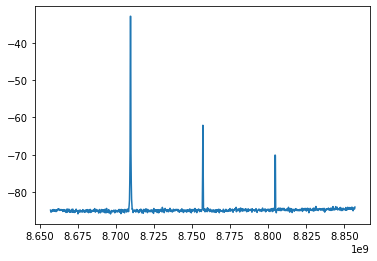

In [12]:
sa.configure_sweep(center=8.7571e9, span=200e6, ref_power = -20)

# Plot
freqs, amps = sa.sweep()
plt.plot(freqs, amps)

Configured sweep! Sweep info: 
{'center': 4165000000.0Hz, 'span': 200000000.0Hz, 'rbw': 250000.0Hz, 'ref_power': -20dBm, 'status': 0, 'sweep_length': 1000, 'start_freq': 4065100000.0, 'bin_size': 200000.0}


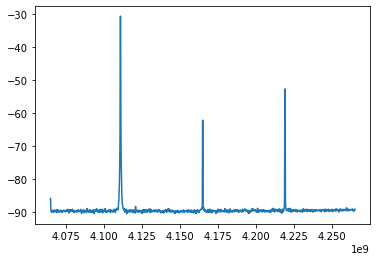

In [13]:
sa.configure_sweep(center=4.165e9, span=200e6, ref_power = -20)

# Plot
freqs, amps = sa.sweep()
plt.plot(freqs, amps)

In [19]:
job.halt()

True

## Resonator spectroscopy

2021-04-20 11:05:33,768 - qm - INFO - Flags: 
2021-04-20 11:05:33,769 - qm - INFO - Executing high level program
<class 'numpy.ndarray'>


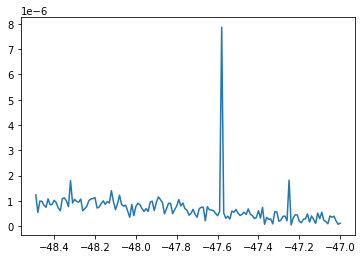

In [33]:
F_START = -47.0e6
F_STOP = -48.5e6
F_STEP = -0.01e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 400
WAIT_TIME = 20000

# amplitude_volts = 0.32*rr_amp_scale
# try to keep amplitude_volts < 0.4 V (otherwise the pulse can be deformed)
rr_amp_scale = 1.
I_list, Q_list = resonator_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                            rr_amp_scale, qubit_amp_scale = None)

amps_rr1 = np.abs(I_list + 1j*Q_list)
freqs = F_VEC/1e6
plt.plot(freqs, amps_rr1)

2021-04-20 10:36:37,633 - qm - INFO - Flags: 
2021-04-20 10:36:37,634 - qm - INFO - Executing high level program


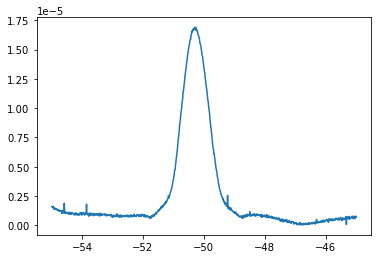

In [21]:
F_START = -45.0e6
F_STOP = -55e6
F_STEP = -0.01e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 20000
rr_amp_scale = 1

I_list, Q_list = resonator_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                            rr_amp_scale, qubit_amp_scale = None)

amps_wide = np.abs(I_list + 1j*Q_list)
freqs = F_VEC/1e6
plt.plot(freqs, amps_wide)



## Powe level sweep of readout pulse

In [37]:
F_START = -45.0e6
F_STOP = -54e6
F_STEP = -0.02e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 10000

rr_db_list = np.arange(-30, 2, 2)
rr_pulse_amp_list = 10**(rr_db_list/10)
rr_amp_list = [None] * len(rr_pulse_amp_list)

for i, rr_amp_scale in enumerate(rr_pulse_amp_list):
    print(rr_amp_scale)
    I_list, Q_list = resonator_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                            rr_amp_scale, qubit_amp_scale = None)
    
    rr_amp_list[i] = np.abs(I_list + 1j*Q_list)
    
    
freqs = F_VEC/1e6

0.001
2021-04-20 11:37:12,369 - qm - INFO - Flags: 
2021-04-20 11:37:12,369 - qm - INFO - Executing high level program
0.001584893192461114
2021-04-20 11:38:27,259 - qm - INFO - Flags: 
2021-04-20 11:38:27,260 - qm - INFO - Executing high level program
0.0025118864315095794
2021-04-20 11:39:42,217 - qm - INFO - Flags: 
2021-04-20 11:39:42,218 - qm - INFO - Executing high level program
0.003981071705534973
2021-04-20 11:40:57,616 - qm - INFO - Flags: 
2021-04-20 11:40:57,617 - qm - INFO - Executing high level program
0.00630957344480193
2021-04-20 11:42:12,849 - qm - INFO - Flags: 
2021-04-20 11:42:12,850 - qm - INFO - Executing high level program
0.01
2021-04-20 11:43:27,848 - qm - INFO - Flags: 
2021-04-20 11:43:27,849 - qm - INFO - Executing high level program
0.015848931924611134
2021-04-20 11:44:42,707 - qm - INFO - Flags: 
2021-04-20 11:44:42,707 - qm - INFO - Executing high level program
0.025118864315095794
2021-04-20 11:45:57,885 - qm - INFO - Flags: 
2021-04-20 11:45:57,885 - 

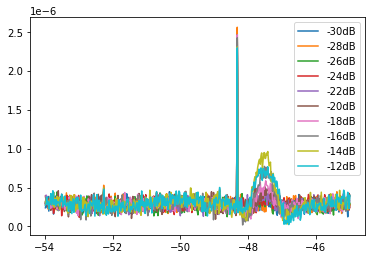

In [48]:
fig, axe = plt.subplots()
for i, rr_amp_scale in enumerate(rr_pulse_amp_list[:10]):
    axe.plot(freqs,rr_amp_list[i], label ="{0}dB".format(rr_db_list[i]))
    axe.legend()
plt.show()

In [40]:
np.savetxt("rr_spec_sweep_power.txt",rr_amp_list)

## Powe level sweep of readout pulse when qubit is in $|e\rangle$

In [50]:
F_START = -45.0e6
F_STOP = -54e6
F_STEP = -0.02e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 10000

rr_db_list = np.arange(-30, 2, 2)
rr_pulse_amp_list = 10**(rr_db_list/10)
rr_amp_list = [None] * len(rr_pulse_amp_list)

for i, rr_amp_scale in enumerate(rr_pulse_amp_list):
    print(rr_amp_scale)
    I_list, Q_list = resonator_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                            rr_amp_scale, qubit_amp_scale = 1)
    
    rr_amp_list[i] = np.abs(I_list + 1j*Q_list)
    
    
freqs = F_VEC/1e6

0.001
2021-04-20 12:05:17,317 - qm - INFO - Flags: 
2021-04-20 12:05:17,317 - qm - INFO - Executing high level program
0.001584893192461114
2021-04-20 12:06:33,656 - qm - INFO - Flags: 
2021-04-20 12:06:33,657 - qm - INFO - Executing high level program
0.0025118864315095794
2021-04-20 12:07:50,658 - qm - INFO - Flags: 
2021-04-20 12:07:50,659 - qm - INFO - Executing high level program
0.003981071705534973
2021-04-20 12:09:07,673 - qm - INFO - Flags: 
2021-04-20 12:09:07,674 - qm - INFO - Executing high level program
0.00630957344480193
2021-04-20 12:10:24,815 - qm - INFO - Flags: 
2021-04-20 12:10:24,815 - qm - INFO - Executing high level program
0.01
2021-04-20 12:11:41,835 - qm - INFO - Flags: 
2021-04-20 12:11:41,836 - qm - INFO - Executing high level program
0.015848931924611134
2021-04-20 12:12:58,776 - qm - INFO - Flags: 
2021-04-20 12:12:58,776 - qm - INFO - Executing high level program
0.025118864315095794
2021-04-20 12:14:15,834 - qm - INFO - Flags: 
2021-04-20 12:14:15,835 - 

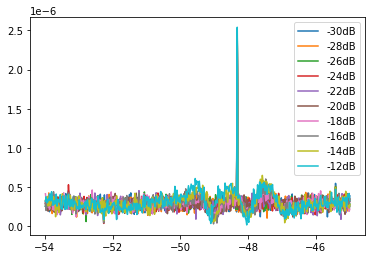

In [57]:
fig, axe = plt.subplots()
for i, rr_amp_scale in enumerate(rr_pulse_amp_list[0:10]):
    axe.plot(freqs,rr_amp_list[i], label ="{0}dB".format(rr_db_list[i]))
    axe.legend()
plt.show()

In [58]:
np.savetxt("rr_spec_sweep_power_saturation.txt",rr_amp_list)

## Qubit spectroscopy

In [10]:
q_lo_freq=4.165e9
rr_lo_freq=8.7571e9

F_START = -40.0e6
F_STOP = -60.0e6
F_STEP = -0.1e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 70000

rr_amp_scale = 0.02
rr_IF = -47.5e6
qubit_amp_scale = 1.

lb_q.frequency = q_lo_freq

I_list, Q_list = qubit_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                        rr_amp_scale, rr_IF, qubit_amp_scale)


Successfully set frequency to 4.16E+09
2021-04-20 14:38:51,991 - qm - INFO - Flags: 
2021-04-20 14:38:51,992 - qm - INFO - Executing high level program


No handles with labels found to put in legend.


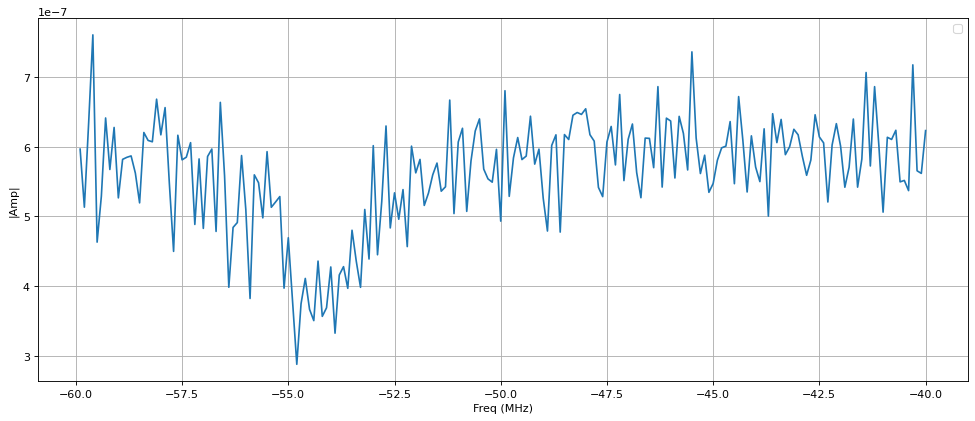

In [11]:
amps = np.abs(I_list + 1j*Q_list)
freqs = F_VEC/1e6

plt.figure(figsize=(15, 6), dpi=80)
plt.plot(freqs, amps)
plt.xlabel('Freq (MHz)')
plt.ylabel('|Amp|')
plt.grid()
plt.legend()

In [60]:
np.savetxt("qubit_spec.txt",amps)

In [14]:
q_lo_freq=4.165e9
rr_lo_freq=8.7571e9

F_START = -10.0e6
F_STOP = -70.0e6
F_STEP = -0.1e6
F_VEC = np.arange(F_START, F_STOP, F_STEP)
REPS = 4000
WAIT_TIME = 70000

rr_amp_scale = 0.02
rr_IF = -47.5e6
qubit_amp_scale = 1.

lb_q.frequency = q_lo_freq

I_list, Q_list = qubit_spectroscopy.run(qm, F_START, F_STOP, F_STEP, REPS, WAIT_TIME, 
                                        rr_amp_scale, rr_IF, qubit_amp_scale)


Successfully set frequency to 4.16E+09
2021-04-20 13:27:55,333 - qm - INFO - Flags: 
2021-04-20 13:27:55,334 - qm - INFO - Executing high level program


No handles with labels found to put in legend.


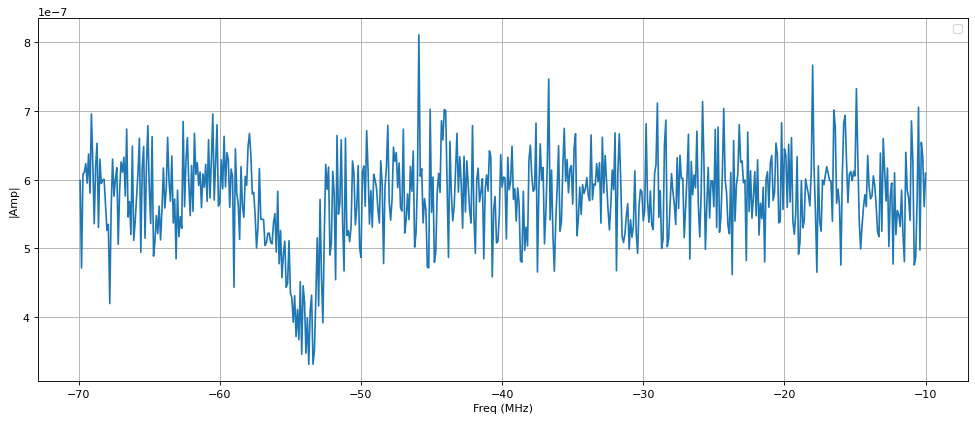

In [15]:
amps = np.abs(I_list + 1j*Q_list)
freqs = F_VEC/1e6

plt.figure(figsize=(15, 6), dpi=80)
plt.plot(freqs, amps)
plt.xlabel('Freq (MHz)')
plt.ylabel('|Amp|')
plt.grid()
plt.legend()

In [16]:
np.savetxt("qubit_spec2.txt",amps)

## Power Rabi

In [14]:
REPS = 4000
AMP_START = -1.6
AMP_STOP = 1.6
AMP_STEP = 0.01
WAIT_TIME = 20000
rr_amp_scale = 0.02

I_list, Q_list, a = power_rabi.run(qm, AMP_START, AMP_STOP, AMP_STEP, REPS, 
                                WAIT_TIME, rr_amp_scale, pulse = 'gaussian')

2021-04-20 14:44:05,351 - qm - INFO - Flags: 
2021-04-20 14:44:05,352 - qm - INFO - Executing high level program


No handles with labels found to put in legend.


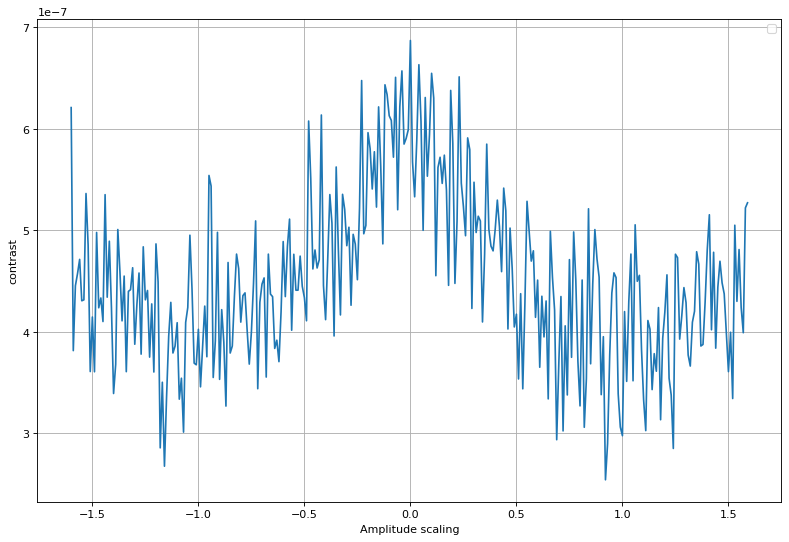

In [15]:
amps = np.abs(I_list + 1j*Q_list)
AMP_VEC = np.arange(AMP_START, AMP_STOP, AMP_STEP)

plt.figure(figsize=(12, 8), dpi=80)
plt.plot(AMP_VEC, amps)

plt.xlabel('Amplitude scaling')
plt.ylabel('contrast')
plt.grid()
plt.legend()

In [16]:
# Processing the data
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params=[0.003, 0.01, 0.001]):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit


# Build a fitting tool for finding the right amplitude
# #(initial parameters to be adapted according to qubit and RR frequencies)
I_params, I_fit = fit_function(
    a,
    I_list,
    lambda x, A, drive_period, phi: (A * np.cos(2 * np.pi * x / drive_period - phi)),
    [0.004, 0.5, 0.0],
)
Q_params, Q_fit = fit_function(
    a,
    Q_list,
    lambda x, A, drive_period, phi: (A * np.cos(2 * np.pi * x / drive_period - phi)),
    [0.003, 0.5, 0.1],
)


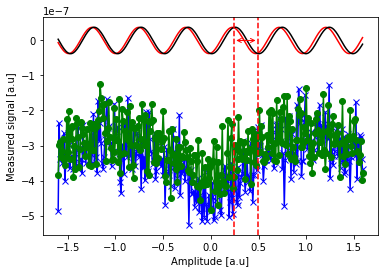

The amplitude required to perform a X gate is 0.24506970258279248


In [17]:
plt.figure()
plt.plot(a, I_list, marker="x", color="blue", label="I")
plt.plot(a, Q_list, marker="o", color="green", label="Q")
plt.plot(a, I_fit, color="red", label="Sinusoidal fit")
plt.plot(a, Q_fit, color="black", label="Sinusoidal fit")
plt.xlabel("Amplitude [a.u]")
plt.ylabel("Measured signal [a.u]")
plt.axvline(I_params[1] / 2, color="red", linestyle="--")
plt.axvline(I_params[1], color="red", linestyle="--")
plt.annotate(
    "",
    xy=(I_params[1], 0),
    xytext=(I_params[1] / 2, 0),
    arrowprops=dict(arrowstyle="<->", color="red"),
)
plt.annotate("$\pi$", xy=(I_params[1] / 2 - 0.03, 0.1), color="red")
plt.show()

print("The amplitude required to perform a X gate is", I_params[1] / 2)